In [1]:
from Bio import Entrez, SeqIO
import pandas
import requests
import numpy
from src.matchmatrix import build_matrix
from multiprocessing import Pool
import matplotlib.pyplot as plt

## Getting sequences

In [2]:
query = "https://www.uniprot.org/uniprot/?query=taxonomy:%22Mammalia%20[40674]%22%20name:%22hemoglobin%20subunit%20{}%22%20reviewed:yes&format=tab&columns=organism,database(EMBL)&sort=score"
subunit = "beta"
df = pandas.read_csv(query.format(subunit), sep="\t")
df_beta = df[~df["Cross-reference (EMBL)"].isnull()].groupby("Organism").first().reset_index()
print(df_beta.count())
df_beta.head()

Organism                  40
Cross-reference (EMBL)    40
dtype: int64


,Organism,Cross-reference (EMBL)
0,Ailuropoda melanoleuca (Giant panda),AY753985;
1,Alouatta belzebul (Red-handed howler monkey),AY279110;
2,Aotus azarae (Southern owl monkey) (Aotus azarai),AY279113;
3,Ateles paniscus (Black spider monkey) (Red-fac...,AY279117;
4,Bos mutus grunniens (Wild yak) (Bos grunniens),DQ277007;


In [3]:
ids = df_beta["Cross-reference (EMBL)"].str.split(";", n=1, expand=True)[0].tolist()

In [4]:
!rm data/hemoglobin_beta.fasta

In [5]:
with open("data/hemoglobin_beta.fasta", "a") as f:
    for seq in ids:
        resp = requests.get(f"https://www.ebi.ac.uk/ena/browser/api/fasta/{seq}")
        if resp.status_code == 200 and len(resp.text) < 6500:
            f.write(resp.text)
        else:
            print(resp.status_code, len(resp.text))
    

200 56901
200 1630633
200 1246286


## Building Matrices

In [6]:
!rm -rf data/images/beta/
!rm -rf meta-data-files
!mkdir -p data/images/beta/

In [7]:
def save_image_by_matrices(name1, name2, seq1, seq2, max_window, min_window):
    matrix = build_matrix(seq1, seq2, max_window, min_window)
    plt.imsave(f"data/images/beta/hemoglobin_{name1}x{name2}.png",(matrix*max_rgb/max_window).astype(numpy.uint8))

In [8]:
%%time
max_window = 20
min_window = 1
procs = 6
max_rgb = 255

with open("data/hemoglobin_beta.fasta") as handle:
    sequences = SeqIO.parse(handle, "fasta")
    with Pool(procs) as pool:
        pool.starmap(
            save_image_by_matrices,
            [(s.description, s.description, s.seq, s.seq, max_window, min_window) for s in sequences]
        )

CPU times: user 1.7 s, sys: 792 ms, total: 2.49 s
Wall time: 32min 29s


## Searching similarities

In [9]:
from annoy import AnnoyIndex
from DeepImageSearch import Index, LoadData, SearchImage, config
image_list = LoadData().from_folder(['data/images/beta'])
Index(image_list).Start()
search = SearchImage()

2021-12-01 18:44:47.692404: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-01 18:44:47.692459: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-12-01 18:45:48.458016: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-01 18:45:48.458076: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-01 18:45:48.458100: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-PEBVG10A): /proc/driver/nvidia/version does not exist
2021-12-01 18:45:48.458367: I tensorflow/core/platform/cpu_fe

Image Meta Information Saved: [meta-data-files/image_data_features.pkl]


37it [00:00, 1784.69it/s]


Saved the Indexed File:[meta-data-files/image_features_vectors.ann]


In [10]:
u = AnnoyIndex(search.f, 'euclidean')
u.load(config.image_features_vectors_ann)

True

In [17]:
with open("data/hemoglobin_beta.fasta") as handle:
    num_seqs = len(list(SeqIO.parse(handle, "fasta")))

df = pandas.DataFrame()
for i in range(num_seqs):
    index_list = u.get_nns_by_item(i, -1, search_k=-1, include_distances=True)
    images = search.image_data.iloc[index_list[0]]['images_paths'].to_list()
    df = pandas.concat([df,
        pandas.DataFrame(
            zip(index_list[1], images),
            columns=[images[0], "gene"]
        ).set_index("gene")
    ], axis=1)

In [18]:
df = df.sort_index(axis=1).sort_index(axis=0)
df.head()

,"data/images/beta/hemoglobin_ENA|AF205408|AF205408.1 Pongo pygmaeus beta-globin gene, exon 3 and partial cds.xENA|AF205408|AF205408.1 Pongo pygmaeus beta-globin gene, exon 3 and partial cds..png","data/images/beta/hemoglobin_ENA|AF205409|AF205409.1 Colobus guereza beta-globin gene, exon 3 and partial cds.xENA|AF205409|AF205409.1 Colobus guereza beta-globin gene, exon 3 and partial cds..png","data/images/beta/hemoglobin_ENA|AY279110|AY279110.1 Alouatta belzebul beta globin gene, complete cds.xENA|AY279110|AY279110.1 Alouatta belzebul beta globin gene, complete cds..png","data/images/beta/hemoglobin_ENA|AY279111|AY279111.1 Callithrix jacchus beta globin gene, complete cds.xENA|AY279111|AY279111.1 Callithrix jacchus beta globin gene, complete cds..png","data/images/beta/hemoglobin_ENA|AY279112|AY279112.1 Pithecia pithecia beta globin gene, complete cds.xENA|AY279112|AY279112.1 Pithecia pithecia beta globin gene, complete cds..png","data/images/beta/hemoglobin_ENA|AY279113|AY279113.1 Aotus azarai beta globin gene, complete cds.xENA|AY279113|AY279113.1 Aotus azarai beta globin gene, complete cds..png","data/images/beta/hemoglobin_ENA|AY279114|AY279114.1 Lagothrix lagotricha beta globin gene, complete cds.xENA|AY279114|AY279114.1 Lagothrix lagotricha beta globin gene, complete cds..png","data/images/beta/hemoglobin_ENA|AY279115|AY279115.1 Cebus apella beta globin gene, complete cds.xENA|AY279115|AY279115.1 Cebus apella beta globin gene, complete cds..png","data/images/beta/hemoglobin_ENA|AY279116|AY279116.1 Saimiri sciureus beta globin gene, complete cds.xENA|AY279116|AY279116.1 Saimiri sciureus beta globin gene, complete cds..png","data/images/beta/hemoglobin_ENA|AY279117|AY279117.1 Ateles paniscus beta globin gene, complete cds.xENA|AY279117|AY279117.1 Ateles paniscus beta globin gene, complete cds..png",...,data/images/beta/hemoglobin_ENA|X00376|X00376.1 Bovine adult beta-globin genexENA|X00376|X00376.1 Bovine adult beta-globin gene.png,"data/images/beta/hemoglobin_ENA|X02345|X02345.1 P.troglodytes beta-globin gene, exons 1-3xENA|X02345|X02345.1 P.troglodytes beta-globin gene, exons 1-3.png",data/images/beta/hemoglobin_ENA|X05665|X05665.1 M.cynomolgus beta-globin gene (partial)xENA|X05665|X05665.1 M.cynomolgus beta-globin gene (partial).png,data/images/beta/hemoglobin_ENA|X14727|X14727.1 Sheep beta-B globin genexENA|X14727|X14727.1 Sheep beta-B globin gene.png,data/images/beta/hemoglobin_ENA|X16417|X16417.1 Rat mRNA for beta-globinxENA|X16417|X16417.1 Rat mRNA for beta-globin.png,data/images/beta/hemoglobin_ENA|X61109|X61109.1 G.gorilla beta-globin genexENA|X61109|X61109.1 G.gorilla beta-globin gene.png,data/images/beta/hemoglobin_ENA|X64178|X64178.1 M.auratus mRNA for beta-like z-globin genexENA|X64178|X64178.1 M.auratus mRNA for beta-like z-globin gene.png,data/images/beta/hemoglobin_ENA|X86791|X86791.1 Sus scrofa beta-globin genexENA|X86791|X86791.1 Sus scrofa beta-globin gene.png,data/images/beta/hemoglobin_ENA|Y00347|Y00347.1 Lepus europaeus adult beta-globin genexENA|Y00347|Y00347.1 Lepus europaeus adult beta-globin gene.png,data/images/beta/hemoglobin_ENA|Z69592|Z69592.1 S.crassicaudata HBB gene.xENA|Z69592|Z69592.1 S.crassicaudata HBB gene..png
gene,,,,,,,,,,,,,,,,,,,,,
"data/images/beta/hemoglobin_ENA|AF205408|AF205408.1 Pongo pygmaeus beta-globin gene, exon 3 and partial cds.xENA|AF205408|AF205408.1 Pongo pygmaeus beta-globin gene, exon 3 and partial cds..png",0.000000,0.110822,0.276856,0.230347,0.324861,0.343981,0.369740,0.348001,0.329599,0.219749,...,0.294139,0.552222,0.605012,0.426936,0.179437,0.585921,0.290254,0.470758,0.434365,0.424184
"data/images/beta/hemoglobin_ENA|AF205409|AF205409.1 Colobus guereza beta-globin gene, exon 3 and partial cds.xENA|AF205409|AF205409.1 Colobus guereza beta-globin gene, exon 3 and partial cds..png",0.110822,0.000000,0.310679,0.256675,0.351826,0.369262,0.393028,0.374120,0.353624,0.238497,...,0.319192,0.559433,0.616000,0.447030,0.220200,0.587810,0.333358,0.469210,0.457409,0.420641
"da

## Making tree

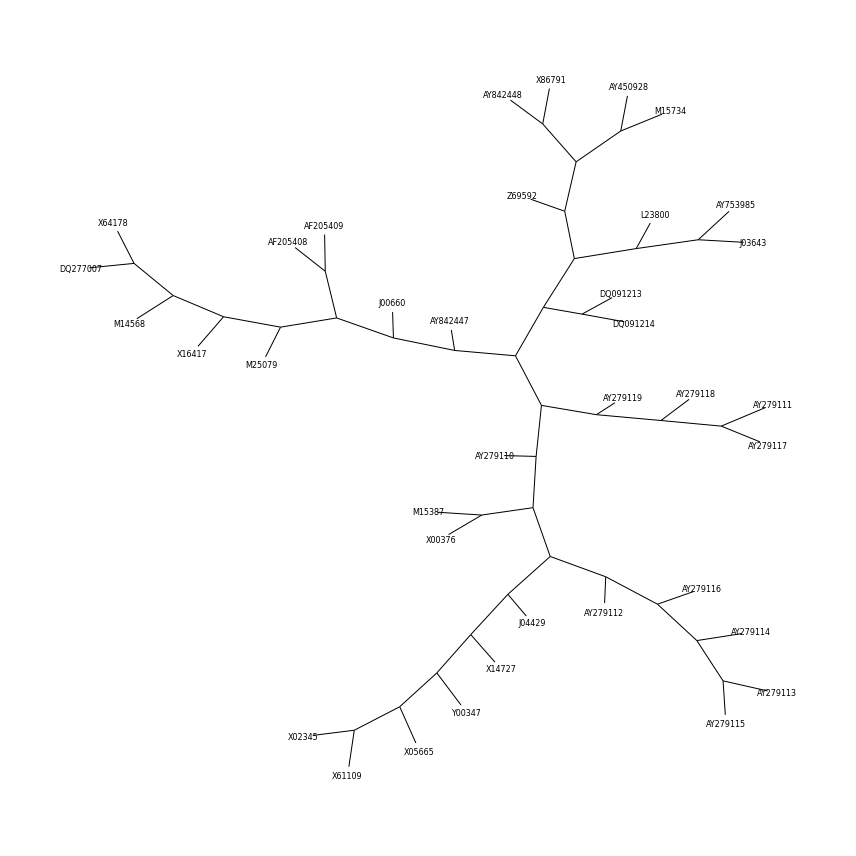

In [127]:
import networkx as nx
import biotite.sequence.phylo as phylo
tree = phylo.neighbor_joining(df.to_numpy())
graph = tree.as_graph().to_undirected()
fig = plt.figure(figsize=(12.0, 12.0))
ax = fig.gca()
ax.axis("off")
pos = nx.kamada_kawai_layout(graph)
node_labels = {i: name.split("/")[-1].split("|")[-2] for i, name in enumerate(df.columns)}
nx.draw_networkx(
    graph, pos, ax=ax, labels=node_labels, node_color="white", font_size=8,
    # Draw a white background behind the labeled nodes
    # for better readability
    node_size=[300 if isinstance(node, int) else 0 for node in graph]
)
fig.tight_layout()

plt.show()

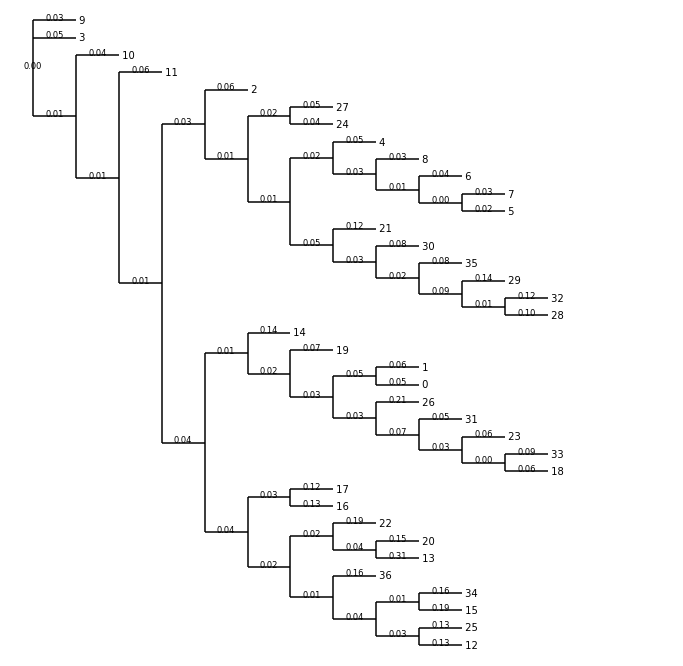

In [125]:
from Bio import Phylo
from io import StringIO

fig = plt.figure(figsize=(12.0, 12.0))
ax = fig.gca()
ax.axis("off")
t = Phylo.read(StringIO(tree.to_newick()), "newick", values_are_confidence=True)
t.ladderize()
Phylo.draw(t, show_confidence=True, axes=ax, branch_labels=lambda clade: "{:.2f}".format(clade.confidence))

In [20]:
columns = df.columns

## Comparing

In [59]:
raw_clustalw = """
     1: ENA|L23800|L23800.1      100.00   46.70   64.79   54.47   51.92   50.79   68.40   58.23   59.87   58.52   48.75   59.36   53.28   73.07   52.39   51.75   46.33   55.51   72.25   70.02   38.20   57.02   57.37   38.44   57.52   51.88   51.75   51.48   55.73   51.96   56.43   55.91   52.13   55.60   55.96   50.78   54.10   69.54
     2: ENA|J03643|J03643.1       46.70  100.00   60.80   52.20   49.97   49.59   65.79   54.60   56.25   51.53   53.42   54.86   52.43   70.04   51.39   51.55   50.92   51.64   67.87   64.74   40.10   55.42   55.15   39.12   55.33   54.32   54.76   55.44   54.89   54.47   54.94   54.56   54.60   54.23   55.01   60.54   61.53   71.72
     3: ENA|X64178|X64178.1       64.79   60.80  100.00   64.25   66.24   63.38   67.64   66.00   72.39   69.15   69.48   72.68   66.19   74.24   68.41   66.98   66.98   65.92   68.50   68.67   45.34   72.93   70.74   43.87   70.31   66.36   66.36   65.42   65.42   65.89   65.89   67.06   66.36   65.89   66.59   66.75   71.84   70.18
     4: ENA|AY842447|AY842447.2   54.47   52.20   64.25  100.00   80.95   57.25   73.29   63.22   63.98   62.77   62.69   65.57   61.79   80.94   61.27   61.34   61.17   64.11   79.38   71.55   45.16   67.76   67.73   45.47   67.47   64.68   65.97   65.20   64.84   65.44   65.66   65.29   65.39   64.65   65.68   51.92   50.77   67.01
     5: ENA|AY842448|AY842448.2   51.92   49.97   66.24   80.95  100.00   56.69   73.62   60.18   62.97   62.11   62.55   63.24   61.51   81.93   60.22   59.86   60.21   62.66   80.00   71.98   42.58   65.22   64.69   43.13   64.69   65.09   66.22   65.45   65.76   65.73   66.11   65.73   65.86   65.42   65.93   51.54   48.93   67.89
     6: ENA|V00722|V00722.1       50.79   49.59   63.38   57.25   56.69  100.00   86.39   62.13   63.19   65.32   61.93   65.93   59.19   78.32   59.88   58.30   58.84   63.70   74.69   73.02   42.36   66.18   66.79   42.19   67.10   65.05   64.58   65.08   65.49   65.35   64.96   65.19   65.19   65.08   65.18   52.90   54.13   65.98
     7: ENA|X16417|X16417.1       68.40   65.79   67.64   73.29   73.62   86.39  100.00   74.91   78.11   77.41   78.45   78.45   76.39   80.28   77.81   76.32   76.95   76.75   77.14   73.50   45.16   82.64   83.13   45.67   83.13   78.61   77.31   78.61   78.77   78.61   77.96   77.96   78.44   77.81   77.80   64.84   74.32   65.86
     8: ENA|DQ091213|DQ091213.1   58.23   54.60   66.00   63.22   60.18   62.13   74.91  100.00   75.66   72.09   69.90   69.53   68.76   81.72   67.05   66.15   66.10   72.60   80.96   72.44   46.90   71.08   72.13   46.93   72.51   72.58   72.57   72.46   72.60   72.86   72.75   72.90   73.20   72.66   72.77   54.95   55.86   69.92
     9: ENA|DQ091214|DQ091214.1   59.87   56.25   72.39   63.98   62.97   63.19   78.11   75.66  100.00   72.06   69.57   69.85   68.76   82.34   67.12   66.93   67.04   71.32   83.53   71.15   46.20   70.32   70.79   45.44   71.04   71.58   71.86   72.37   72.13   72.17   71.58   71.66   72.05   71.25   71.63   56.37   55.31   73.67
    10: ENA|M15734|M15734.1       58.52   51.53   69.15   62.77   62.11   65.32   77.41   72.09   72.06  100.00   74.40   74.91   71.04   84.98   67.63   66.62   67.34   77.15   83.39   76.71   45.20   78.83   79.97   45.75   79.97   78.67   79.00   79.23   79.31   79.31   79.23   79.40   79.11   78.53   79.33   53.70   55.02   69.49
    11: ENA|Y00347|Y00347.1       48.75   53.42   69.48   62.69   62.55   61.93   78.45   69.90   69.57   74.40  100.00   94.37   63.51   83.63   65.82   65.23   56.91   66.30   83.01   79.14   47.31   63.73   64.80   47.57   64.58   62.72   62.99   63.98   73.23   62.89   69.96   73.29   63.38   73.14   73.58   56.70   59.56   72.29
    12: ENA|J00660|J00660.1       59.36   54.86   72.68   65.57   63.24   65.93   78.45   69.53   69.85   74.91   94.37  100.00   70.16   84.60   68.46   68.10   68.13   73.07   85.01   79.14   46.86   76.39   77.04   47.30   76.60   76.18   76.41   76.56   76.18   76.80   75.37   76.03   76.54   76.30   76.53   57.06   59.14   73.14
    13: ENA|X86791|X86791.1       53.28   52.43   66.19   61.79   61.51   59.19   76.39   68.76   68.76   71.04   63.51   70.16  100.00   86.72   70.83   70.06   69.41   67.63   83.83   76.13   43.38   67.85   69.10   43.67   68.94   67.53   67.62   69.56   69.10   68.27   68.10   69.05   68.48   68.94   69.48   54.47   54.74   67.45
    14: ENA|DQ277007|DQ277007.1   73.07   70.04   74.24   80.94   81.93   78.32   80.28   81.72   82.34   84.98   83.63   84.60   86.72  100.00   99.01   94.26   94.44   84.93   89.02   77.73   49.63   89.19   88.45   50.74   88.21   87.48   86.89   87.08   86.89   87.48   86.69   87.08   86.69   86.39   86.89   70.76   73.52   73.61
    15: ENA|X00376|X00376.1       52.39   51.39   68.41   61.27   60.22   59.88   77.81   67.05   67.12   67.63   65.82   68.46   70.83   99.01  100.00   92.89   92.89   66.73   84.94   78.24   45.12   67.87   68.40   45.53   68.47   69.37   69.92   69.64   69.67   69.66   69.58   69.89   69.93   69.77   69.94   52.62   50.04   68.59
    16: ENA|M15387|M15387.1       51.75   51.55   66.98   61.34   59.86   58.30   76.32   66.15   66.93   66.62   65.23   68.10   70.06   94.26   92.89  100.00   96.89   66.37   84.15   76.48   44.83   66.89   67.29   45.40   67.29   68.47   68.91   68.95   68.66   68.86   68.72   69.14   69.13   68.91   69.18   52.28   49.89   67.54
    17: ENA|X14727|X14727.1       46.33   50.92   66.98   61.17   60.21   58.84   76.95   66.10   67.04   67.34   56.91   68.13   69.41   94.44   92.89   96.89  100.00   65.88   84.76   77.36   44.46   66.63   67.04   44.58   66.84   62.36   62.85   62.62   68.76   62.94   68.15   69.01   63.39   68.85   69.00   52.11   50.59   68.59
    18: ENA|J04429|J04429.1       55.51   51.64   65.92   64.11   62.66   63.70   76.75   72.60   71.32   77.15   66.30   73.07   67.63   84.93   66.73   66.37   65.88  100.00   87.06   79.27   45.89   74.58   74.88   46.56   74.89   76.32   77.00   78.21   78.18   77.40   76.71   77.56   76.78   77.26   77.41   55.42   55.40   69.85
    19: ENA|AY753985|AY753985.1   72.25   67.87   68.50   79.38   80.00   74.69   77.14   80.96   83.53   83.39   83.01   85.01   83.83   89.02   84.94   84.15   84.76   87.06  100.00   79.05   47.25   90.10   89.37   47.92   89.13   85.89   86.20   85.74   85.58   86.20   86.20   85.12   85.89   84.71   85.58   68.39   76.35   71.82
    20: ENA|M25079|M25079.1       70.02   64.74   68.67   71.55   71.98   73.02   73.50   72.44   71.15   76.71   79.14   79.14   76.13   77.73   78.24   76.48   77.36   79.27   79.05  100.00   44.41   85.16   89.01   43.73   88.46   84.40   83.97   84.83   84.40   85.04   84.40   84.62   85.26   83.97   84.40   64.96   68.02   71.43
    21: ENA|AF205409|AF205409.1   38.20   40.10   45.34   45.16   42.58   42.36   45.16   46.90   46.20   45.20   47.31   46.86   43.38   49.63   45.12   44.83   44.46   45.89   47.25   44.41  100.00   50.35   50.45   92.84   50.45   49.16   49.04   49.35   49.58   49.08   49.27   49.27   48.96   48.64   49.07   40.59   42.00   41.95
    22: ENA|X05665|X05665.1       57.02   55.42   72.93   67.76   65.22   66.18   82.64   71.08   70.32   78.83   63.73   76.39   67.85   89.19   67.87   66.89   66.63   74.58   90.10   85.16   50.35  100.00   93.67   50.76   93.47   88.61   89.20   89.98   89.77   89.65   89.82   89.42   89.80   88.51   89.45   56.70   56.62   78.80
    23: ENA|X02345|X02345.1       57.37   55.15   70.74   67.73   64.69   66.79   83.13   72.13   70.79   79.97   64.80   77.04   69.10   88.45   68.40   67.29   67.04   74.88   89.37   89.01   50.45   93.67  100.00   50.45   98.11   89.10   89.82   91.34   91.14   90.23   90.40   90.51   90.34   89.72   90.32   57.25   56.55   78.26
    24: ENA|AF205408|AF205408.1   38.44   39.12   43.87   45.47   43.13   42.19   45.67   46.93   45.44   45.75   47.57   47.30   43.67   50.74   45.53   45.40   44.58   46.56   47.92   43.73   92.84   50.76   50.45  100.00   50.55   49.26   49.53   49.45   50.00   49.65   49.80   49.61   49.49   49.13   49.69   39.64   42.40   40.33
    25: ENA|X61109|X61109.1       57.52   55.33   70.31   67.47   64.69   67.10   83.13   72.51   71.04   79.97   64.58   76.60   68.94   88.21   68.47   67.29   66.84   74.89   89.13   88.46   50.45   93.47   98.11   50.55  100.00   89.23   90.04   91.56   91.36   90.36   90.44   90.57   90.29   90.00   90.54   57.05   56.63   77.72
    26: ENA|AY279116|AY279116.1   51.88   54.32   66.36   64.68   65.09   65.05   78.61   72.58   71.58   78.67   62.72   76.18   67.53   87.48   69.37   68.47   62.36   76.32   85.89   84.40   49.16   88.61   89.10   49.26   89.23  100.00   94.45   93.16   93.71   94.39   94.17   94.13   94.29   93.96   93.91   58.04   57.41   70.77
    27: ENA|AY279115|AY279115.1   51.75   54.76   66.36   65.97   66.22   64.58   77.31   72.57   71.86   79.00   62.99   76.41   67.62   86.89   69.92   68.91   62.85   77.00   86.20   83.97   49.04   89.20   89.82   49.53   90.04   94.45  100.00   93.77   94.47   94.84   94.86   94.98   94.65   94.54   94.72   57.62   58.35   71.03
    28: ENA|AY279112|AY279112.1   51.48   55.44   65.42   65.20   65.45   65.08   78.61   72.46   72.37   79.23   63.98   76.56   69.56   87.08   69.64   68.95   62.62   78.21   85.74   84.83   49.35   89.98   91.34   49.45   91.56   93.16   93.77  100.00   96.05   93.83   95.34   94.95   94.25   94.30   94.65   58.26   57.96   70.77
    29: ENA|AY279119|AY279119.1   55.73   54.89   65.42   64.84   65.76   65.49   78.77   72.60   72.13   79.31   73.23   76.18   69.10   86.89   69.67   68.66   68.76   78.18   85.58   84.40   49.58   89.77   91.14   50.00   91.36   93.71   94.47   96.05  100.00   95.18   95.06   94.75   95.10   93.96   94.49   58.36   58.01   70.51
    30: ENA|AY279113|AY279113.1   51.96   54.47   65.89   65.44   65.73   65.35   78.61   72.86   72.17   79.31   62.89   76.80   68.27   87.48   69.66   68.86   62.94   77.40   86.20   85.04   49.08   89.65   90.23   49.65   90.36   94.39   94.84   93.83   95.18  100.00   95.53   95.46   94.84   94.76   95.16   58.08   57.89   71.03
    31: ENA|AY279110|AY279110.1   56.43   54.94   65.89   65.66   66.11   64.96   77.96   72.75   71.58   79.23   69.96   75.37   68.10   86.69   69.58   68.72   68.15   76.71   86.20   84.40   49.27   89.82   90.40   49.80   90.44   94.17   94.86   95.34   95.06   95.53  100.00   96.18   96.67   94.78   95.04   58.08   58.32   70.00
    32: ENA|AY279117|AY279117.1   55.91   54.56   67.06   65.29   65.73   65.19   77.96   72.90   71.66   79.40   73.29   76.03   69.05   87.08   69.89   69.14   69.01   77.56   85.12   84.62   49.27   89.42   90.51   49.61   90.57   94.13   94.98   94.95   94.75   95.46   96.18  100.00   96.81   95.14   96.47   57.94   57.39   71.03
    33: ENA|AY279114|AY279114.1   52.13   54.60   66.36   65.39   65.86   65.19   78.44   73.20   72.05   79.11   63.38   76.54   68.48   86.69   69.93   69.13   63.39   76.78   85.89   85.26   48.96   89.80   90.34   49.49   90.29   94.29   94.65   94.25   95.10   94.84   96.67   96.81  100.00   95.00   95.26   58.61   57.85   71.28
    34: ENA|AY279111|AY279111.1   55.60   54.23   65.89   64.65   65.42   65.08   77.81   72.66   71.25   78.53   73.14   76.30   68.94   86.39   69.77   68.91   68.85   77.26   84.71   83.97   48.64   88.51   89.72   49.13   90.00   93.96   94.54   94.30   93.96   94.76   94.78   95.14   95.00  100.00   96.59   57.18   57.88   70.00
    35: ENA|AY279118|AY279118.1   55.96   55.01   66.59   65.68   65.93   65.18   77.80   72.77   71.63   79.33   73.58   76.53   69.48   86.89   69.94   69.18   69.00   77.41   85.58   84.40   49.07   89.45   90.32   49.69   90.54   93.91   94.72   94.65   94.49   95.16   95.04   96.47   95.26   96.59  100.00   57.78   57.62   71.28
    36: ENA|Z69592|Z69592.1       50.78   60.54   66.75   51.92   51.54   52.90   64.84   54.95   56.37   53.70   56.70   57.06   54.47   70.76   52.62   52.28   52.11   55.42   68.39   64.96   40.59   56.70   57.25   39.64   57.05   58.04   57.62   58.26   58.36   58.08   58.08   57.94   58.61   57.18   57.78  100.00   60.05   80.68
    37: ENA|AY450928|AY450928.1   54.10   61.53   71.84   50.77   48.93   54.13   74.32   55.86   55.31   55.02   59.56   59.14   54.74   73.52   50.04   49.89   50.59   55.40   76.35   68.02   42.00   56.62   56.55   42.40   56.63   57.41   58.35   57.96   58.01   57.89   58.32   57.39   57.85   57.88   57.62   60.05  100.00   85.23
    38: ENA|M14568|M14568.1       69.54   71.72   70.18   67.01   67.89   65.98   65.86   69.92   73.67   69.49   72.29   73.14   67.45   73.61   68.59   67.54   68.59   69.85   71.82   71.43   41.95   78.80   78.26   40.33   77.72   70.77   71.03   70.77   70.51   71.03   70.00   71.03   71.28   70.00   71.28   80.68   85.23  100.00

"""

In [60]:
clustal_list = list(filter(None, [i.replace("\n", "") if (i not in ["", "\n"]) and not i.endswith(":") else None for i in raw_clustalw.split(" ")]))

In [61]:
df_clustal = pandas.DataFrame(numpy.array(clustal_list).reshape((38,39)))

In [63]:
df_clustal = df_clustal.set_index(0)

In [64]:
df_clustal.columns = df_clustal.index.tolist()

In [65]:
df_clustal.head()

,ENA|L23800|L23800.1,ENA|J03643|J03643.1,ENA|X64178|X64178.1,ENA|AY842447|AY842447.2,ENA|AY842448|AY842448.2,ENA|V00722|V00722.1,ENA|X16417|X16417.1,ENA|DQ091213|DQ091213.1,ENA|DQ091214|DQ091214.1,ENA|M15734|M15734.1,...,ENA|AY279119|AY279119.1,ENA|AY279113|AY279113.1,ENA|AY279110|AY279110.1,ENA|AY279117|AY279117.1,ENA|AY279114|AY279114.1,ENA|AY279111|AY279111.1,ENA|AY279118|AY279118.1,ENA|Z69592|Z69592.1,ENA|AY450928|AY450928.1,ENA|M14568|M14568.1
0,,,,,,,,,,,,,,,,,,,,,
ENA|L23800|L23800.1,100.00,46.70,64.79,54.47,51.92,50.79,68.40,58.23,59.87,58.52,...,55.73,51.96,56.43,55.91,52.13,55.60,55.96,50.78,54.10,69.54
ENA|J03643|J03643.1,46.70,100.00,60.80,52.20,49.97,49.59,65.79,54.60,56.25,51.53,...,54.89,54.47,54.94,54.56,54.60,54.23,55.01,60.54,61.53,71.72
ENA|X64178|X64178.1,64.79,60.80,100.00,64.25,66.24,63.38,67.64,66.00,72.39,69.15,...,65.42,65.89,65.89,67.06,66.36,65.89,66.59,66.75,71.84,70.18
ENA|AY842447|AY842447.2,54.47,52.20,64.25,100.00,80.95,57.25,73.29,63.22,63.98,62.77,...,64.84,65.44,65.66,65.29,65.39,64.65,65.68,51.92,50.77,67.01
ENA|AY842448|AY842448.2,51.92,49.97,66.24,80.95,100.00,56.69,73.62,60.18,62.97,62.11,...,65.76,65.73,66.11,65.73,65.86,65.42,65.93,51.54,48.93,67.89


In [68]:
df_clustal = df_clustal.sort_index(axis=1).sort_index(axis=0)
df_clustal.head()

,ENA|AF205408|AF205408.1,ENA|AF205409|AF205409.1,ENA|AY279110|AY279110.1,ENA|AY279111|AY279111.1,ENA|AY279112|AY279112.1,ENA|AY279113|AY279113.1,ENA|AY279114|AY279114.1,ENA|AY279115|AY279115.1,ENA|AY279116|AY279116.1,ENA|AY279117|AY279117.1,...,ENA|X00376|X00376.1,ENA|X02345|X02345.1,ENA|X05665|X05665.1,ENA|X14727|X14727.1,ENA|X16417|X16417.1,ENA|X61109|X61109.1,ENA|X64178|X64178.1,ENA|X86791|X86791.1,ENA|Y00347|Y00347.1,ENA|Z69592|Z69592.1
0,,,,,,,,,,,,,,,,,,,,,
ENA|AF205408|AF205408.1,100.00,92.84,49.80,49.13,49.45,49.65,49.49,49.53,49.26,49.61,...,45.53,50.45,50.76,44.58,45.67,50.55,43.87,43.67,47.57,39.64
ENA|AF205409|AF205409.1,92.84,100.00,49.27,48.64,49.35,49.08,48.96,49.04,49.16,49.27,...,45.12,50.45,50.35,44.46,45.16,50.45,45.34,43.38,47.31,40.59
ENA|AY279110|AY279110.1,49.80,49.27,100.00,94.78,95.34,95.53,96.67,94.86,94.17,96.18,...,69.58,90.40,89.82,68.15,77.96,90.44,65.89,68.10,69.96,58.08
ENA|AY279111|AY279111.1,49.13,48.64,94.78,100.00,94.30,94.76,95.00,94.54,93.96,95.14,...,69.77,89.72,88.51,68.85,77.81,90.00,65.89,68.94,73.14,57.18
ENA|AY279112|AY279112.1,49.45,49.35,95.34,94.30,100.00,93.83,94.25,93.77,93.16,94.95,...,69.64,91.34,89.98,62.62,78.61,91.56,65.42,69.56,63.98,58.26


In [69]:
df.columns = [column.split("_")[1].split(" ")[0] for column in df.columns.tolist()]

IndexError: list index out of range

In [29]:
df.index = [column.split("_")[1].split(" ")[0] for column in df.index.tolist()]

In [70]:
df.head()

,ENA|AF205408|AF205408.1,ENA|AF205409|AF205409.1,ENA|AY279110|AY279110.1,ENA|AY279111|AY279111.1,ENA|AY279112|AY279112.1,ENA|AY279113|AY279113.1,ENA|AY279114|AY279114.1,ENA|AY279115|AY279115.1,ENA|AY279116|AY279116.1,ENA|AY279117|AY279117.1,...,ENA|X00376|X00376.1,ENA|X02345|X02345.1,ENA|X05665|X05665.1,ENA|X14727|X14727.1,ENA|X16417|X16417.1,ENA|X61109|X61109.1,ENA|X64178|X64178.1,ENA|X86791|X86791.1,ENA|Y00347|Y00347.1,ENA|Z69592|Z69592.1
ENA|AF205408|AF205408.1,0.000000,0.110822,0.276856,0.230347,0.324861,0.343981,0.369740,0.348001,0.329599,0.219749,...,0.294139,0.552222,0.605012,0.426936,0.179437,0.585921,0.290254,0.470758,0.434365,0.424184
ENA|AF205409|AF205409.1,0.110822,0.000000,0.310679,0.256675,0.351826,0.369262,0.393028,0.374120,0.353624,0.238497,...,0.319192,0.559433,0.616000,0.447030,0.220200,0.587810,0.333358,0.469210,0.457409,0.420641
ENA|AY279110|AY279110.1,0.276856,0.310679,0.000000,0.131637,0.118519,0.135281,0.154062,0.139197,0.126684,0.140949,...,0.156259,0.404584,0.459308,0.246583,0.344646,0.450436,0.418368,0.423358,0.251977,0.377093
ENA|AY279111|AY279111.1,0.230347,0.256675,0.131637,0.000000,0.188255,0.181028,0.219943,0.195627,0.170608,0.081130,...,0.156282,0.420769,0.480624,0.274136,0.300285,0.466470,0.387071,0.413518,0.294479,0.378819
ENA|AY279112|AY279112.1,0.324861,0.351826,0.118519,0.188255,0.000000,0.119437,0.115647,0.124237,0.122657,0.186930,...,0.171502,0.390208,0.439099,0.242368,0.383909,0.429750,0.451059,0.437603,0.244562,0.367042


In [78]:
df = df.astype(float)
df_clustal = df_clustal.astype(float)

In [75]:
df_clustal = df_clustal.loc[set(df_clustal.columns).intersection(set(df.columns)), set(df_clustal.columns).intersection(set(df.columns))]

In [79]:
df_clustal = df_clustal /100

In [80]:
df_clustal = 1 - df_clustal

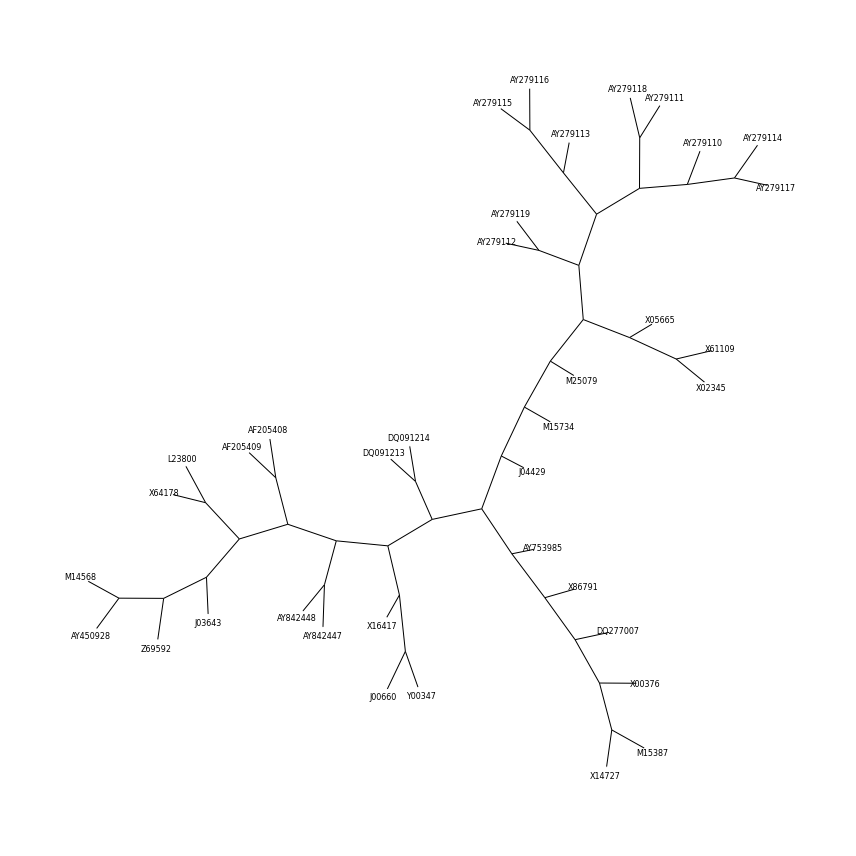

In [90]:
import networkx as nx
import biotite.sequence.phylo as phylo
tree = phylo.neighbor_joining(df_clustal.to_numpy())
graph = tree.as_graph().to_undirected()
fig = plt.figure(figsize=(12.0, 12.0))
ax = fig.gca()
ax.axis("off")
pos = nx.kamada_kawai_layout(graph)
node_labels = {i: name.split("/")[-1].split("|")[-2] for i, name in enumerate(df_clustal.columns)}
nx.draw_networkx(
    graph, pos, ax=ax, labels=node_labels, node_color="white", font_size=8,
    # Draw a white background behind the labeled nodes
    # for better readability
    node_size=[300 if isinstance(node, int) else 0 for node in graph]
)
fig.tight_layout()

plt.show()

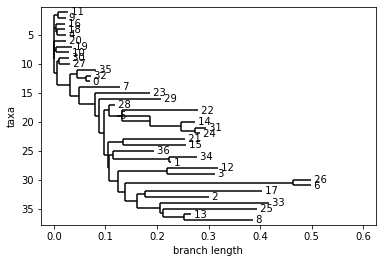

In [91]:
from Bio import Phylo
from io import StringIO

t = Phylo.read(StringIO(tree.to_newick()), "newick")
t.ladderize()
Phylo.draw(t)

### Corretos (22)

In [14]:
columns[0],columns[1]

('data/images/beta/hemoglobin_ENA|AF205408|AF205408.1 Pongo pygmaeus beta-globin gene, exon 3 and partial cds.xENA|AF205408|AF205408.1 Pongo pygmaeus beta-globin gene, exon 3 and partial cds..png',
 'data/images/beta/hemoglobin_ENA|AF205409|AF205409.1 Colobus guereza beta-globin gene, exon 3 and partial cds.xENA|AF205409|AF205409.1 Colobus guereza beta-globin gene, exon 3 and partial cds..png')

In [15]:
columns[33],columns[29],columns[30]

('data/images/beta/hemoglobin_ENA|X61109|X61109.1 G.gorilla beta-globin genexENA|X61109|X61109.1 G.gorilla beta-globin gene.png',
 'data/images/beta/hemoglobin_ENA|X02345|X02345.1 P.troglodytes beta-globin gene, exons 1-3xENA|X02345|X02345.1 P.troglodytes beta-globin gene, exons 1-3.png',
 'data/images/beta/hemoglobin_ENA|X05665|X05665.1 M.cynomolgus beta-globin gene (partial)xENA|X05665|X05665.1 M.cynomolgus beta-globin gene (partial).png')

In [16]:
columns[7],columns[5],columns[6],columns[8],columns[4]

('data/images/beta/hemoglobin_ENA|AY279115|AY279115.1 Cebus apella beta globin gene, complete cds.xENA|AY279115|AY279115.1 Cebus apella beta globin gene, complete cds..png',
 'data/images/beta/hemoglobin_ENA|AY279113|AY279113.1 Aotus azarai beta globin gene, complete cds.xENA|AY279113|AY279113.1 Aotus azarai beta globin gene, complete cds..png',
 'data/images/beta/hemoglobin_ENA|AY279114|AY279114.1 Lagothrix lagotricha beta globin gene, complete cds.xENA|AY279114|AY279114.1 Lagothrix lagotricha beta globin gene, complete cds..png',
 'data/images/beta/hemoglobin_ENA|AY279116|AY279116.1 Saimiri sciureus beta globin gene, complete cds.xENA|AY279116|AY279116.1 Saimiri sciureus beta globin gene, complete cds..png',
 'data/images/beta/hemoglobin_ENA|AY279112|AY279112.1 Pithecia pithecia beta globin gene, complete cds.xENA|AY279112|AY279112.1 Pithecia pithecia beta globin gene, complete cds..png')

In [17]:
columns[24],columns[28],columns[31],columns[21]

('data/images/beta/hemoglobin_ENA|M15387|M15387.1 Goat alanine-beta-globin gene, complete cds.xENA|M15387|M15387.1 Goat alanine-beta-globin gene, complete cds..png',
 'data/images/beta/hemoglobin_ENA|X00376|X00376.1 Bovine adult beta-globin genexENA|X00376|X00376.1 Bovine adult beta-globin gene.png',
 'data/images/beta/hemoglobin_ENA|X14727|X14727.1 Sheep beta-B globin genexENA|X14727|X14727.1 Sheep beta-B globin gene.png',
 'data/images/beta/hemoglobin_ENA|J04429|J04429.1 T.syrichta beta globin gene, complete cds.xENA|J04429|J04429.1 T.syrichta beta globin gene, complete cds..png')

In [18]:
columns[16],columns[17]

('data/images/beta/hemoglobin_ENA|DQ091213|DQ091213.1 Dasypus novemcinctus beta-globin gene, complete cds.xENA|DQ091213|DQ091213.1 Dasypus novemcinctus beta-globin gene, complete cds..png',
 'data/images/beta/hemoglobin_ENA|DQ091214|DQ091214.1 Bradypus tridactylus beta-globin gene, complete cds.xENA|DQ091214|DQ091214.1 Bradypus tridactylus beta-globin gene, complete cds..png')

In [19]:
columns[14],columns[27]

('data/images/beta/hemoglobin_ENA|AY842447|AY842447.2 Scalopus aquaticus isolate EM-1 hemoglobin subunit delta (HBD) gene, complete cds.xENA|AY842447|AY842447.2 Scalopus aquaticus isolate EM-1 hemoglobin subunit delta (HBD) gene, complete cds..png',
 'data/images/beta/hemoglobin_ENA|V00722|V00722.1 Mouse gene for beta-1-globin.xENA|V00722|V00722.1 Mouse gene for beta-1-globin..png')

In [20]:
columns[22],columns[37]

('data/images/beta/hemoglobin_ENA|L23800|L23800.1 Tachyglossus aculeatus beta-globin homolog (HBB) gene, complete cds.xENA|L23800|L23800.1 Tachyglossus aculeatus beta-globin homolog (HBB) gene, complete cds..png',
 'data/images/beta/hemoglobin_ENA|Z69592|Z69592.1 S.crassicaudata HBB gene.xENA|Z69592|Z69592.1 S.crassicaudata HBB gene..png')

In [21]:
columns[34],columns[23]

('data/images/beta/hemoglobin_ENA|X64178|X64178.1 M.auratus mRNA for beta-like z-globin genexENA|X64178|X64178.1 M.auratus mRNA for beta-like z-globin gene.png',
 'data/images/beta/hemoglobin_ENA|M14568|M14568.1 Marsupial cat beta-globin gene mRNA, partial cds.xENA|M14568|M14568.1 Marsupial cat beta-globin gene mRNA, partial cds..png')

### Talvez (5)

In [22]:
columns[9],columns[3],columns[10] 

('data/images/beta/hemoglobin_ENA|AY279117|AY279117.1 Ateles paniscus beta globin gene, complete cds.xENA|AY279117|AY279117.1 Ateles paniscus beta globin gene, complete cds..png',
 'data/images/beta/hemoglobin_ENA|AY279111|AY279111.1 Callithrix jacchus beta globin gene, complete cds.xENA|AY279111|AY279111.1 Callithrix jacchus beta globin gene, complete cds..png',
 'data/images/beta/hemoglobin_ENA|AY279118|AY279118.1 Callimico goeldii beta globin gene, complete cds.xENA|AY279118|AY279118.1 Callimico goeldii beta globin gene, complete cds..png')

In [23]:
columns[11]

'data/images/beta/hemoglobin_ENA|AY279119|AY279119.1 Callicebus torquatus beta globin gene, complete cds.xENA|AY279119|AY279119.1 Callicebus torquatus beta globin gene, complete cds..png'

In [24]:
columns[19]

'data/images/beta/hemoglobin_ENA|J00660|J00660.1 Rabbit beta1-globin with 2 ivs, type 2 allele.xENA|J00660|J00660.1 Rabbit beta1-globin with 2 ivs, type 2 allele..png'

### Errados (11)

In [25]:
columns[36]

'data/images/beta/hemoglobin_ENA|Y00347|Y00347.1 Lepus europaeus adult beta-globin genexENA|Y00347|Y00347.1 Lepus europaeus adult beta-globin gene.png'

In [26]:
columns[18]

'data/images/beta/hemoglobin_ENA|DQ277007|DQ277007.1 Bos grunniens hemoglobin beta subunit (HBB) mRNA, complete cds.xENA|DQ277007|DQ277007.1 Bos grunniens hemoglobin beta subunit (HBB) mRNA, complete cds..png'

In [27]:
columns[2]

'data/images/beta/hemoglobin_ENA|AY279110|AY279110.1 Alouatta belzebul beta globin gene, complete cds.xENA|AY279110|AY279110.1 Alouatta belzebul beta globin gene, complete cds..png'

In [28]:
columns[12],columns[25]

('data/images/beta/hemoglobin_ENA|AY450928|AY450928.1 Macropus eugenii beta globin gene, complete cds.xENA|AY450928|AY450928.1 Macropus eugenii beta globin gene, complete cds..png',
 'data/images/beta/hemoglobin_ENA|M15734|M15734.1 Lemur (brown) beta-globin gene, complete cds.xENA|M15734|M15734.1 Lemur (brown) beta-globin gene, complete cds..png')

In [29]:
columns[13],columns[20]

('data/images/beta/hemoglobin_ENA|AY753985|AY753985.1 Ailuropoda melanoleuca hemoglobin beta mRNA, complete cds.xENA|AY753985|AY753985.1 Ailuropoda melanoleuca hemoglobin beta mRNA, complete cds..png',
 'data/images/beta/hemoglobin_ENA|J03643|J03643.1 Opossum beta-hemoglobin beta-M gene, complete cds.xENA|J03643|J03643.1 Opossum beta-hemoglobin beta-M gene, complete cds..png')

In [30]:
columns[15],columns[35]

('data/images/beta/hemoglobin_ENA|AY842448|AY842448.2 Scapanus orarius isolate CM-3 hemoglobin subunit delta (HBD) gene, complete cds.xENA|AY842448|AY842448.2 Scapanus orarius isolate CM-3 hemoglobin subunit delta (HBD) gene, complete cds..png',
 'data/images/beta/hemoglobin_ENA|X86791|X86791.1 Sus scrofa beta-globin genexENA|X86791|X86791.1 Sus scrofa beta-globin gene.png')

In [31]:
columns[26],columns[32]

('data/images/beta/hemoglobin_ENA|M25079|M25079.1 Human sickle cell beta-globin mRNA, complete cds.xENA|M25079|M25079.1 Human sickle cell beta-globin mRNA, complete cds..png',
 'data/images/beta/hemoglobin_ENA|X16417|X16417.1 Rat mRNA for beta-globinxENA|X16417|X16417.1 Rat mRNA for beta-globin.png')

In [37]:
from scipy.spatial.distance import jensenshannon


In [38]:
divergence = jensenshannon(df, df_clustal)

ValueError: operands could not be broadcast together with shapes (37,37) (38,38) 

In [ ]:
pandas.Series(divergence, index=df.index)

In [67]:
df.corrwith(df_clustal)

ENA|AF205408|AF205408.1    0.509579
ENA|AF205409|AF205409.1    0.547337
ENA|AY279110|AY279110.1    0.419240
ENA|AY279111|AY279111.1    0.358331
ENA|AY279112|AY279112.1    0.420071
ENA|AY279113|AY279113.1    0.466336
ENA|AY279114|AY279114.1    0.472379
ENA|AY279115|AY279115.1    0.470078
ENA|AY279116|AY279116.1    0.463081
ENA|AY279117|AY279117.1    0.299012
ENA|AY279118|AY279118.1    0.305319
ENA|AY279119|AY279119.1    0.281763
ENA|AY450928|AY450928.1    0.105673
ENA|AY753985|AY753985.1    0.110033
ENA|AY842447|AY842447.2    0.033492
ENA|AY842448|AY842448.2    0.180240
ENA|DQ091213|DQ091213.1    0.254738
ENA|DQ091214|DQ091214.1    0.163733
ENA|DQ277007|DQ277007.1   -0.182417
ENA|J00660|J00660.1        0.086667
ENA|J03643|J03643.1        0.408690
ENA|J04429|J04429.1        0.284401
ENA|L23800|L23800.1        0.272898
ENA|M14568|M14568.1       -0.109982
ENA|M15387|M15387.1        0.279116
ENA|M15734|M15734.1       -0.018121
ENA|M25079|M25079.1       -0.048269
ENA|V00722|V00722.1        0

In [73]:
numpy.linalg.eigvals(df) - numpy.linalg.eigvals(df_clustal)

array([-3.04541928e+00,  6.54118955e-01,  4.82034754e-01,  1.24617490e-02,
        1.40228566e+00, -1.36587272e-01, -4.86901011e-02, -1.31952734e-01,
       -1.11429527e-01, -7.66226156e-02,  5.23781099e-01, -6.34686255e-02,
       -5.85205822e-02, -3.89305087e-02, -6.09048918e-02, -4.37704581e-02,
       -4.64455213e-02, -1.40751798e-02, -2.31192377e-03,  2.38740787e-03,
        3.14968961e-02, -1.26601530e-01, -9.80167983e-02,  6.54099529e-02,
        7.77967381e-02,  5.28197052e-02,  5.02179672e-02,  6.68998224e-03,
        6.30413711e-03,  2.75833689e-02,  7.20781004e-02,  7.60525407e-02,
        1.25543865e-01,  9.85406010e-02,  6.53821321e-02,  7.68902792e-02,
        9.95687231e-02,  9.43029322e-02])